# Chapter6 カーネル法

#### カーネル関数
$$
k(\bm{x}, \bm{x}') = \phi(\bm{x})^T \phi(\bm{x}')
$$
- $\phi(\bm{x})$: 特徴空間への非線形写像
- 元の次元から特徴空間次元に移して内積をとる関数
  - 2つのベクトルの類似度を定めるようなもの
- 特徴空間次元に移すメリット
  - 線形分離可能になる
- パラメトリックな線形モデルはカーネル関数の線形和で表現可能

## 6.1 双対表現

多くの線形モデルは双対表現で表すことでカーネル関数が現れる
$$
\text{J}(\bm{w}) = \frac{1}{2} \sum_{n=1}^{N} (\bm{w}^T \phi(\bm{x}_n) - t_n)^2 + \frac{\lambda}{2}\bm{w}^T\bm{w}
$$
wについて解くと、
$$
\bm{w} = \Phi ^ T \bm{a}
$$
$\Phi$は計画行列であり、$\bm{a}$は
$$
a_n = - \frac{1}{\lambda} {\left\{ \bm{w}^T\phi(x_n) - t_n \right\}}
$$
となるベクトルである
これが**双対表現**である

カーネル関数を使ったグラム行列$K=\Phi\Phi^T$を定義すると$\bm{a}$の解は
$$
\bm{a} = (K + \lambda I_N)^{-1} \bm{t}
$$
予測関数は
$$
y(\bm{x}) = \bm{w}^T\phi(\bm{x}) = k(\bm{x})^T (K + \lambda I_N)^{-1} \bm{t}\\
k(\bm{x}) = k(\bm{x}_n, \bm{x})
$$



## 6.2 カーネル関数の構成

$$
k(x, x') = \phi(x)^T \phi(x') = \sum_{i=1}^{M} \phi(x_i) \phi(x_i')
$$
カーネル関数は基底関数の内積であり、それらを合わせた行列がグラム行列である
#### いろいろなカーネル関数
- 一般化された多項式カーネル
$$
k(x, x') = (x^Tx' + c)^M
$$
- ガウスカーネル\
これは無限次元への写像と等価
$$
k(x, x') = \exp {(- \gamma ||x - x'||^2)}
$$
- 生成モデルから構成されるカーネル
$$
k(x, x') = p(x)p(x')
$$
- シグモイドカーネル\
グラム行列が必ずしも半正定値にならない\
サポートベクターマシンとニューラルネットワークが表層的に類似したものになる
$$
k(x, x') = \tanh(ax^Tx' + b)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def polynomial_kernel(x, y, c=1, d=3):
    return (x @ y + c) ** d

def gaussian_kernel(x, y, sigma=1):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

def sigmoid_kernel(x, y, alpha=1, c=0):
    return np.tanh(alpha * np.dot(x, y) + c)

In [3]:
class GaussianKernelRidgeRegression(object):
    def __init__(self, kernel_func=gaussian_kernel, lambda_=1) -> None:
        self.kernel_func = kernel_func
        self.lambda_ = lambda_
        self.dual_variable = None
        
    def fit(self, X, y) -> None:
        K = np.array([[self.kernel_func(xi, xj) for xi in X] for xj in X])
        self.dual_variable = np.linalg.inv(K + self.lambda_ * np.eye(len(X))) @ y
        self.X_train = X
        
    def predict(self, X):
        return [sum(self.dual_variable[i] * self.kernel_func(x, self.X_train[i]) for i in range(len(self.X_train))) for x in X]
        

In [4]:
def true_func(x):
    return 1 - 1.5 * x + np.sin(x) + np.cos(3 * x)

n = 100
x_train = 6 * np.random.rand(n) - 3
y_train = true_func(x_train)

KRR = GaussianKernelRidgeRegression(kernel_func=gaussian_kernel, lambda_=0.01)
KRR.fit(x_train, y_train)

x = np.linspace(-3, 3, 100)
y = KRR.predict(x)

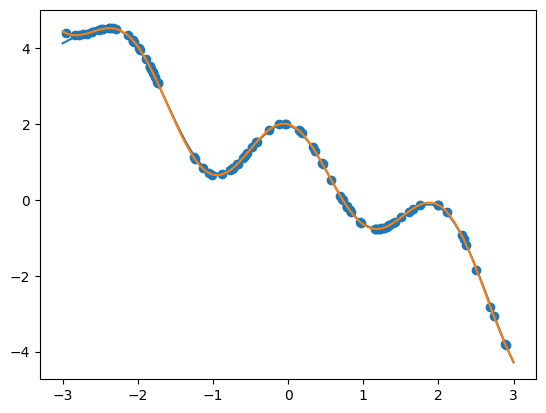

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, true_func(x))
ax.scatter(x_train, y_train)


### Suport Vector Classifier

In [6]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np

In [7]:
# データ生成
X, y = make_circles(n_samples=500, noise=0.05, factor=0.3, random_state=42)
print(X[y==0].shape)
print(X[y==1].shape)

(250, 2)
(250, 2)


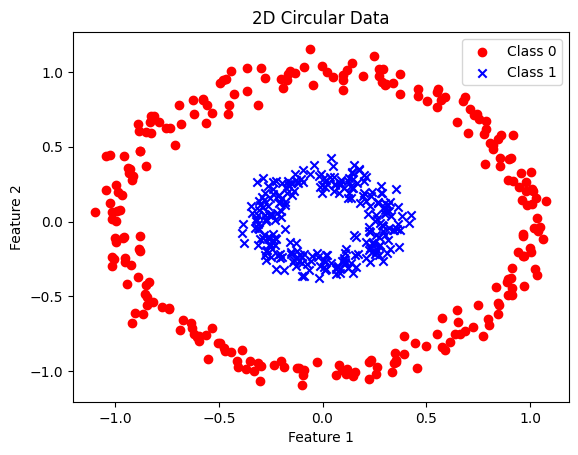

In [8]:
fig, ax = plt.subplots()

ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', marker='o', label='Class 0')
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='x', label='Class 1')
plt.legend()
plt.title('2D Circular Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [9]:
svm_poly = SVC(kernel='poly', degree=2, C=1)
svm_poly.fit(X, y)
support_vectors = svm_poly.support_vectors_
print(support_vectors)

[[-0.5349312  -0.71119699]
 [-0.31320758  0.78011152]
 [-0.87873094 -0.09652873]
 [-0.45417009  0.72173004]
 [ 0.78289666  0.3830468 ]
 [ 0.42620303  0.04505024]
 [ 0.04287937  0.42247895]
 [-0.28785418  0.29039916]
 [-0.31511373  0.26735512]]


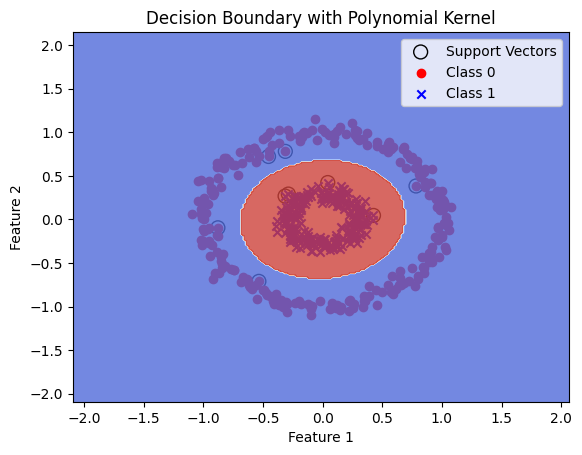

In [10]:
# 決定境界とサポートベクトルの描画関数
def plot_decision_boundary(X, y, model, support_vectors):
    # サポートベクトルのプロット
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')
    
    # データのプロット
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='r', marker='o', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='b', marker='x', label='Class 1')

    # 決定境界のプロット
    h = .02  # ステップサイズ
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap="coolwarm")

    plt.legend()
    plt.title('Decision Boundary with Polynomial Kernel')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# 決定境界の描画
plot_decision_boundary(X, y, svm_poly, support_vectors)

## 6.3 RBFネットワーク

Chapter3 線形回帰モデルでは基底関数の選び方を考えていなかった\
#### 基底関数の選び方
- 動径基底関数がよく用いられる
- RBFはその中心$\mu_j$からの動径のみに依存している
$$
\phi_j(\bm{x}) = h(||\bm{x} - \bm{\mu}_j||)
$$
#### RBFを導入する動機
- 正確に目的変数の値を再現する関数補間\
目標変数のノイズによって過学習する可能性あり
$$
f(\bm{x}) = \sum_{n=1}^N w_n h(||\bm{x} - \bm{x}_n||)
$$
- 入力変数にノイズが含まれる場合の補間\
Nadaraya-Watsonモデル

- 入力変数に確率分布$\nu(\xi)$に従う確率変数$\xi$で表されるノイズが含まれる時、二乗和誤差関数は
$$
E = \frac{1}{2}\sum_{n=1}^{N} \int {\left\{ y(\bm{x}_n + \xi) - t_n \right\}^2}\nu(\xi) d\xi
$$
- yに対する変分法により\
基底関数は正規化されている
$$
y(\bm{x}_n) = \sum_{n=1}^{N} t_n h(\bm{x} - \bm{x}_n)\\
h(\bm{x} - \bm{x}_n) = \frac{\nu(\bm{x} - \bm{x}_n)}{\sum_{n=1}^{N} {\nu(\bm{x} - \bm{x}_n)}}
$$


## 6.4 ガウス過程

ベイズ的な視点においても確率的識別モデルに対して自然にカーネルが現れることを確認する
- ガウス過程とは\
任意の点集合$\left\{x_1, ..., x_n\right\}$に対する$\left\{y_1, ..., y_n\right\}$の同時分布がガウス分布に従うもの
- ガウス過程の考え方\
パラメータwの事前分布p(w)を決めるのではなく、関数y(x)の事前分布p(y)を直接定義

### 6.4.1 線形回帰再訪

線形回帰モデル
$$
y(\bm{x}) = W^T \phi(\bm{x})
$$
を考える
wの事前分布として等方的ガウス分布を考える
$$
p(\bm{w}) = N(\bm{w}|\bm{0}, \alpha^{-1}\bm{I})
$$
訓練データに対応する${y(x_1)...y(x_n)}$の同時分布を求める
$$
\bm{y} = \Phi\bm{w}
$$
とすると
$$
E[\bm{y}] = \Phi E[\bm{w}] = \bm{0}\\
cov[\bm{y}] = E[\bm{y}\bm{y}^T] = \Phi E[\bm{w}\bm{w}^T] \Phi^T = \alpha^{-1}\Phi\Phi^T = \bm{K}
$$
ここでKは
$$
K_{nm} = k(\bm{x}_n, \bm{x}_m) = \alpha^{-1}\phi(\bm{x}_n)^T \phi(\bm{x}_m)
$$

- $w$はガウス分布に従う変数集合\
-その線形結合であるy自身もガウス分布に従う\
-平均と分散を求めれば、yの分布も定まる

### 6.4.2 ガウス過程による回帰

**目標変数にノイズが含まれることを考慮**
$$
t_n = y_n + \epsilon_n
$$
ノイズはガウス分布に従う\
$\bm{y}$が与えられた下での目標値$\bm{t}$の同時分布は等方的なガウス分布に従う
$$
p(\bm{t}|\bm{y}) = N(\bm{t}|\bm{y}, \beta^{-1}\bm{I}_N)
$$
ガウス過程の定義より$\bm{y}$の周辺分布は平均0で共分散がカーネル行列であるガウス分布となる
$$
p(\bm{y}) = N(\bm{y}|\bm{0}, \bm{K})
$$
$\bm{t}$の周辺分布は
$$
p(\bm{t}) = \int p(\bm{t}|\bm{y}) p(\bm{y}) d\bm{y} = N(\bm{t}|\bm{0}, \bm{C})
$$
共分散行列$C$は
$$
C(\bm{x}_n, \bm{x}_m) = k(\bm{x}_n, \bm{x}_m) + \beta^{-1}\delta_{nm}
$$
この結果は$y_n$と$\epsilon_n$が独立なガウス分布であるためその共分散も単純に足すだけでよい事実に基づく\

ガウス過程回帰に用いるカーネル関数としては、以下のように、2次形式の指数を取ったものに、定数と線形の項を加えたものが広く使われている
$$
k(\bm{x}_n, \bm{x}_m) = \theta_0 \exp{\left\{ -\frac{\theta_1}{2}||\bm{x}_n - \bm{x}_m||^2 \right\}} + \theta_2 + \theta_3\bm{x}_n^T \bm{x}_m
$$
予測平均の計算は
$$
\bm{\mu}_* = \bm{K}_*^T\bm{K}^{-1}\bm{y}_{train}
$$
予測共分散の計算は
$$
\bm{\Sigma}_* = \bm{K}_{**} - \bm{K}_*^T\bm{K}^{-1}\bm{K}
$$


In [11]:
import numpy as np
import matplotlib.pyplot as plt

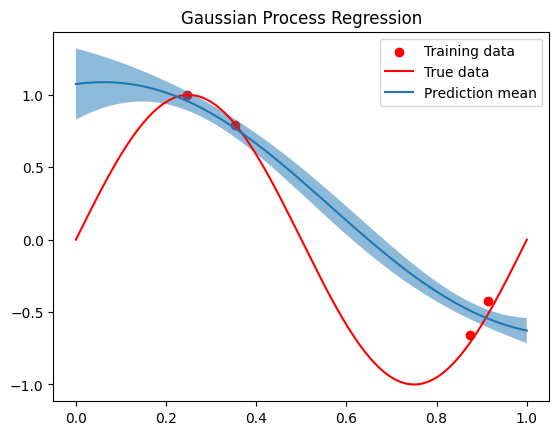

In [75]:
class GaussianProcessRegression:
    def __init__(self, sigma_f=1.0, l=0.5, sigma_n=0.2):
        self.sigma_f = sigma_f
        self.l = l
        self.sigma_n = sigma_n
        self.X_train = None
        self.y_train = None
        self.K = None
        self.K_inv = None

    def kernel_function(self, x1, x2):
        sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.sigma_f**2 * np.exp(-0.5 / self.l**2 * sqdist)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
        # 訓練データ同士のカーネル行列
        K = self.kernel_function(X_train, X_train)
        K += self.sigma_n**2 * np.eye(len(X_train))  # Add noise term
        self.K = K
        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_test):
        # 訓練データとテストデータの相関
        K_s = self.kernel_function(self.X_train, X_test)
        # テストデータ同士のカーネル行列
        K_ss = self.kernel_function(X_test, X_test) + self.sigma_n**2 * np.eye(len(X_test))
        
        K_s_T_K_inv = K_s.T @ self.K_inv
        mu_s = K_s_T_K_inv @ self.y_train
        cov_s = K_ss - K_s_T_K_inv @ K_s
        return mu_s, np.diag(cov_s)
    
    def update(self, X_new, y_new):
        # 新しいデータ点を既存の訓練データに追加
        self.X_train = np.vstack([self.X_train, X_new])
        self.y_train = np.hstack([self.y_train, y_new])

        # 新しいカーネル行列を計算
        K_new = self.kernel_function(self.X_train, self.X_train)
        K_new += self.sigma_n**2 * np.eye(len(self.X_train))

        # 逆行列を更新
        self.K_inv = np.linalg.inv(K_new)
        
    def plot(self, X_test, mu, sigma, X_true=None, y_true=None):
        plt.scatter(self.X_train, self.y_train, c='r', label='Training data')
        if X_true is not None and y_true is not None:
            plt.plot(X_true, y_true, c='r', label='True data')
        plt.plot(X_test, mu, label='Prediction mean')
        plt.fill_between(X_test.ravel(), mu - sigma, mu + sigma, alpha=0.5)
        plt.legend()
        plt.title('Gaussian Process Regression')
        plt.show()

    

# トレーニングデータの生成
X_train1 = np.sort(np.random.uniform(0, 1, 4))[:, None]
y_train1 = np.sin(X_train1 * 2 * np.pi).ravel() + np.random.normal(0, 0.1, len(X_train1))

X_true = np.linspace(0, 1, 1000)
y_true = np.sin(X_true * 2 * np.pi).ravel()

# テストデータ
X_test = np.linspace(0, 1, 100)[:, None]
# インスタンスの作成とフィット
gpr = GaussianProcessRegression()
gpr.fit(X_train1, y_train1)
# 予測
mu_corrected, sigma_corrected = gpr.predict(X_test)
gpr.plot(X_test, mu_corrected, sigma_corrected, X_true, y_true)

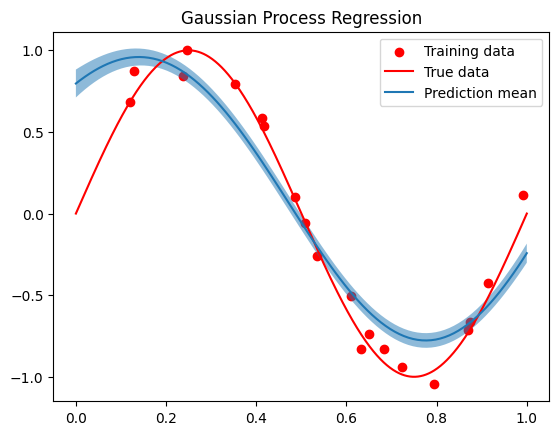

In [76]:
# トレーニングデータの生成 part2
X_train2 = np.sort(np.random.uniform(0, 1, 16))[:, None]
y_train2 = np.sin(X_train2 * 2 * np.pi).ravel() + np.random.normal(0, 0.1, len(X_train2))

gpr.update(X_train2, y_train2)

# 予測
mu_corrected, sigma_corrected = gpr.predict(X_test)
gpr.plot(X_test, mu_corrected, sigma_corrected, X_true, y_true)

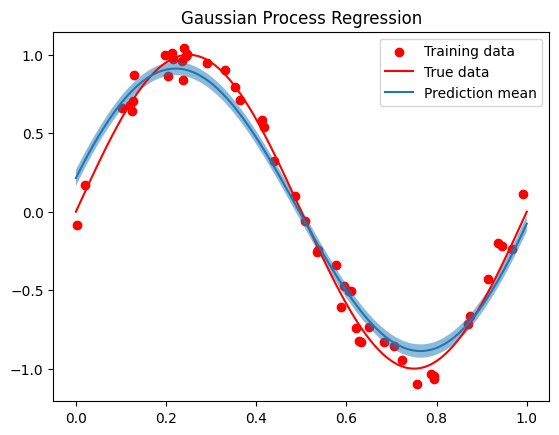

In [77]:
# トレーニングデータの生成 part3
X_train3 = np.sort(np.random.uniform(0, 1, 30))[:, None]
y_train3 = np.sin(X_train3 * 2 * np.pi).ravel() + np.random.normal(0, 0.1, len(X_train3))

gpr.update(X_train3, y_train3)

# 予測
mu_corrected, sigma_corrected = gpr.predict(X_test)
gpr.plot(X_test, mu_corrected, sigma_corrected, X_true, y_true)

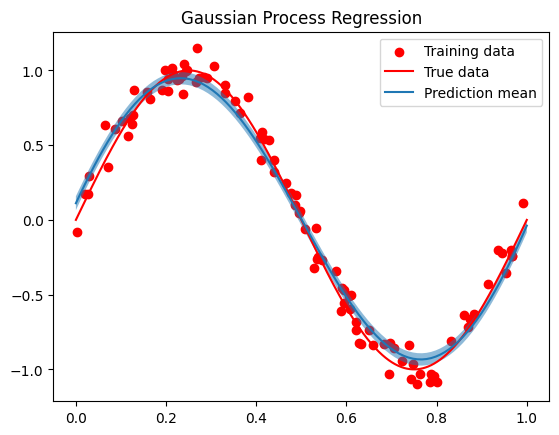

In [78]:
# トレーニングデータの生成 part3
X_train4 = np.sort(np.random.uniform(0, 1, 50))[:, None]
y_train4 = np.sin(X_train4 * 2 * np.pi).ravel() + np.random.normal(0, 0.1, len(X_train4))

gpr.update(X_train4, y_train4)

# 予測
mu_corrected, sigma_corrected = gpr.predict(X_test)
gpr.plot(X_test, mu_corrected, sigma_corrected, X_true, y_true)